In [1]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
import random
import ipywidgets

In [2]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [3]:
batch_size = 256

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="./data",train=True,transform=trans,download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./data",train=False,transform=trans,download=True)

train_iter = data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4)
test_iter = data.DataLoader(mnist_test,batch_size,shuffle=True,num_workers=4)

In [ ]:
# Todo: 这个网络看起来和Softmax操作并不完全等价，根据文档，传统的softmax操作在nn.CrossEntropyLoss中已经被实现了
net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [5]:
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(),lr=0.1)

In [6]:
def accuracy(y_hat, y):
    if len(y_hat) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [7]:
def evaluate_accuracy(net,data_iter):
    net.eval()
    metric = Accumulator(2)
    for X,y in data_iter:
        metric.add(accuracy(net(X),y),y.numel())
    return metric[0] / metric[1]

In [ ]:
train_metrics = []

def train(net, train_iter, loss, num_epoches, updater):
    progress_bar = ipywidgets.IntProgress(value=0,min=0,max=(num_epoches-1))
    display(progress_bar)
    for epoch in range(num_epoches):
        net.train()
        metric = Accumulator(3)
        for X,y in train_iter:
            y_hat = net(X)
            # 因为loss function nn.CrossEntropyLoss的特性，这里输入的y表示的是预测的index，loss function会自动完成LogSoftmax操作。
            # 自动LogSoftmax仅在输入的y为Long型tensor时成立，如果输入的是和y_hat形状一致的概率形式，需要对输入手动进行softmax。
            l = loss(y_hat,y)
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l)*len(y),accuracy(y_hat,y),y.size().numel())
        test_accuracy = evaluate_accuracy(net,test_iter)
        train_metrics.append((epoch,metric[0]/metric[2],metric[1]/metric[2],test_accuracy))
        progress_bar.value = epoch

    for item in train_metrics[-3:-1]:
        print(f"Epoch: {item[0]}, train_loss: {item[1]}, train_accuracy: {item[2]}, test_accuracy: {item[3]}")


In [9]:
train(net,train_iter,loss,20,trainer)

IntProgress(value=0, max=19)

Epoch: 17, train_loss: 0.42324325931866963, train_accuracy: 0.8560166666666666, test_accuracy: 0.834
Epoch: 18, train_loss: 0.42217806595166524, train_accuracy: 0.8554833333333334, test_accuracy: 0.8379


Text(0.5, 1.0, 'Real Group: 8, Calculated Group: 8')

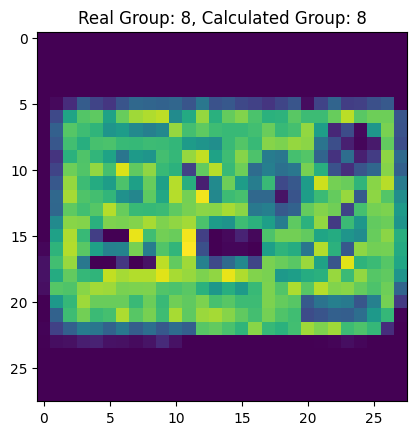

In [10]:
test_item = random.choice(mnist_test)
result = net(test_item[0])
fig, ax = plt.subplots()
ax.imshow(test_item[0].reshape((28,28)))
ax.set_title(f"Real Group: {test_item[1]}, Calculated Group: {result.argmax()}")